# Probabilistic Unsupervised Machine Learning Approach for a Similar Image Recommender System for E-Commerce - Original Methodology

COHNDDS251F-023: A.K.S.D.U. Silva\
COHNDDS251F-027: D.R.M Ludwick\
COHNDDS251F-023: H.M.C.H Pinnakumbura

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from PIL import Image
import os

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import time

## Data preprocessing

### Fixing dataset formatting

In [2]:
# Check for rows with parsing issues using error_bad_lines parameter
styles = pd.read_csv("C:\\Users\\Admin\\DATA\\fashion-dataset\\styles.csv", on_bad_lines='warn')
print(styles.columns)

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')


C:\Users\Admin\AppData\Local\Temp\ipykernel_11944\2454426710.py:2: ParserWarning: Skipping line 6044: expected 10 fields, saw 11
Skipping line 6569: expected 10 fields, saw 11
Skipping line 7399: expected 10 fields, saw 11
Skipping line 7939: expected 10 fields, saw 11
Skipping line 9026: expected 10 fields, saw 11
Skipping line 10264: expected 10 fields, saw 11
Skipping line 10427: expected 10 fields, saw 11
Skipping line 10905: expected 10 fields, saw 11
Skipping line 11373: expected 10 fields, saw 11
Skipping line 11945: expected 10 fields, saw 11
Skipping line 14112: expected 10 fields, saw 11
Skipping line 14532: expected 10 fields, saw 11
Skipping line 15076: expected 10 fields, saw 12
Skipping line 29906: expected 10 fields, saw 11
Skipping line 31625: expected 10 fields, saw 11
Skipping line 33020: expected 10 fields, saw 11
Skipping line 35748: expected 10 fields, saw 11
Skipping line 35962: expected 10 fields, saw 11
Skipping line 37770: expected 10 fields, saw 11
Skipping li

In [3]:
input_file = "C:\\Users\\Admin\\DATA\\fashion-dataset\\styles.csv"
output_file = "C:\\Users\\Admin\\DATA\\fashion-dataset\\data.csv"

with open(input_file, 'r', encoding='utf-8') as infile,open(output_file, 'w', encoding='utf-8', newline='') as outfile:
    reader = csv.reader(infile)
    writer = csv.writer(outfile)
    header = next(reader)
    writer.writerow(header)
    
    rows_fixed = 0
    for i, row in enumerate(reader, start=2):
        if len(row) == 10:
            writer.writerow(row)
            continue

        # merge extra fields into the last field
        fixed_row = row[:9] + [', '.join(row[9:])]
        writer.writerow(fixed_row)
        rows_fixed += 1

    print(f"Fixed {rows_fixed} rows\n")

Fixed 22 rows



### Extracting required data

Based on the original methodology, only the id, masterCategory and subCategory fields are required. Therefore the fields are extracted, and undefined records removed.

In [4]:
# found through images.csv
undefined_images = [39403, 39410, 39401, 39425, 12347]
required_cols = ['id', 'masterCategory', 'subCategory']

df = pd.read_csv(output_file, usecols=required_cols)
df = df.loc[~df['id'].isin(undefined_images)].reset_index(drop=True)

df.to_csv(output_file, index=False)

print(f"\nRows: {df.shape[0]}\nColumns: {df.shape[1]}\n")
print(f"{df.head(5)}\n")
print(df.dtypes)


Rows: 44441
Columns: 3

      id masterCategory subCategory
0  15970        Apparel     Topwear
1  39386        Apparel  Bottomwear
2  59263    Accessories     Watches
3  21379        Apparel  Bottomwear
4  53759        Apparel     Topwear

id                 int64
masterCategory    object
subCategory       object
dtype: object


### Distribution visualization - Categories and Subcategories

C:\Users\Admin\AppData\Local\Temp\ipykernel_11944\2487596978.py:7: UserWarning: The palette list has more values (16) than needed (7), which may not be intended.
  sns.barplot(


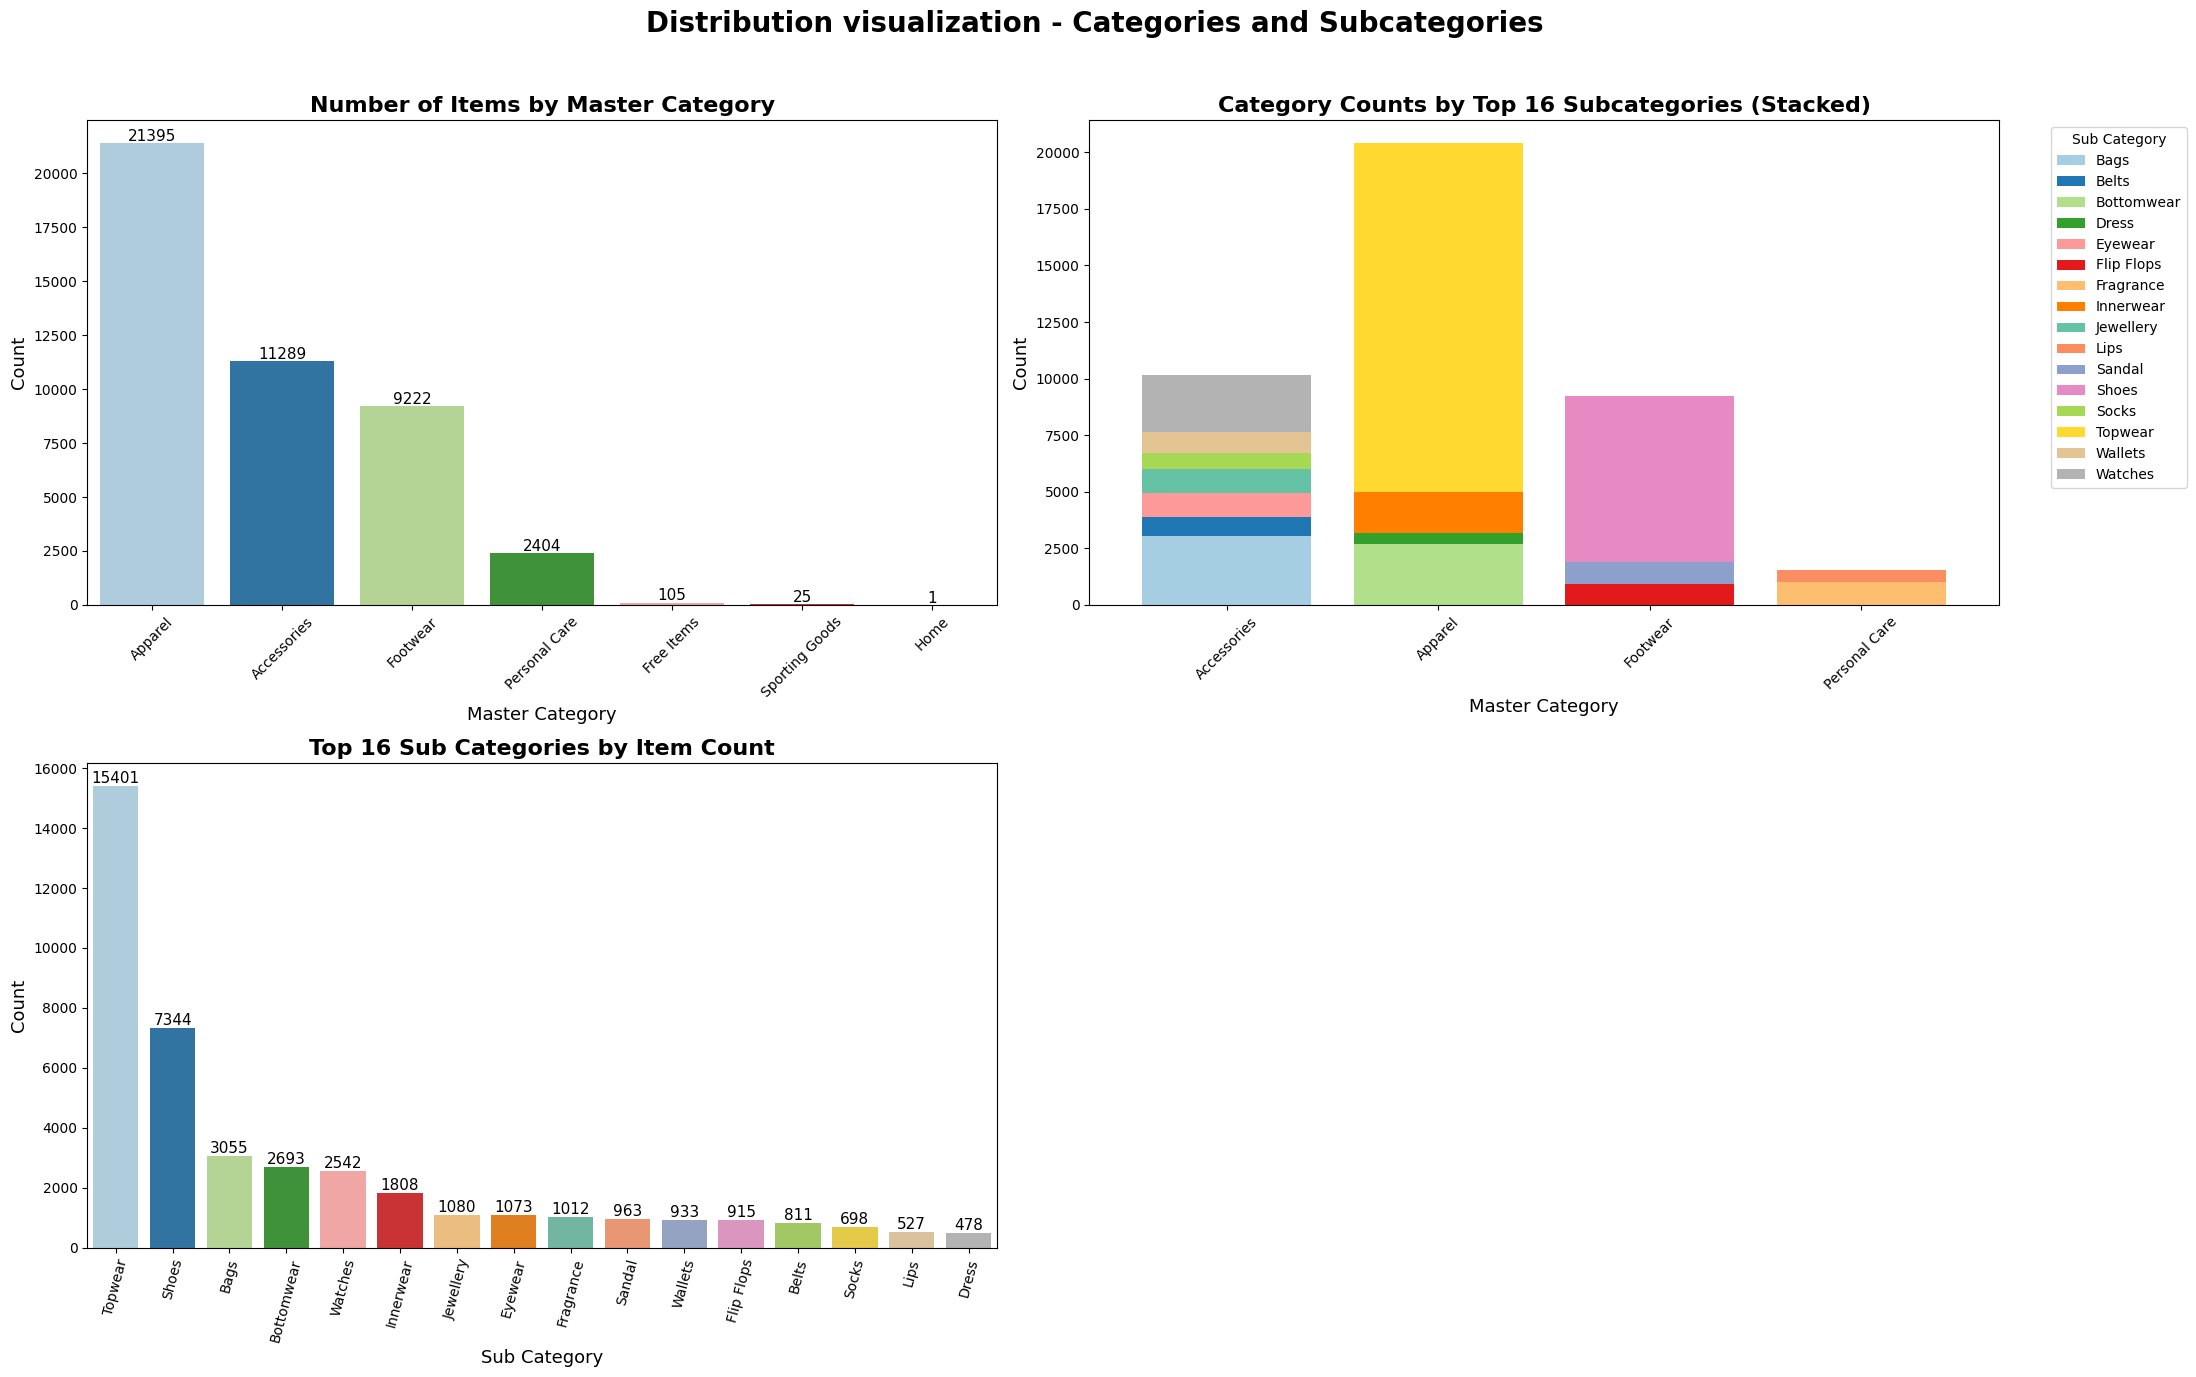

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(22, 14))
fig.suptitle('Distribution visualization - Categories and Subcategories', fontsize=20, fontweight='bold')

cat_counts = df['masterCategory'].value_counts()
palette = sns.color_palette("Paired", 8) + sns.color_palette("Set2", 8)

sns.barplot(
    x=cat_counts.index, y=cat_counts.values, ax=axes[0, 0],
    hue=cat_counts.index, palette=palette, legend=False
)
axes[0, 0].set_title('Number of Items by Master Category', fontsize=16, fontweight='bold')
axes[0, 0].set_xlabel('Master Category', fontsize=13)
axes[0, 0].set_ylabel('Count', fontsize=13)
axes[0, 0].tick_params(axis='x', rotation=45)

for i, v in enumerate(cat_counts.values):
    axes[0, 0].text(i, v + 100, str(v), ha='center', fontsize=11)


subcat_counts = df['subCategory'].value_counts().head(16)
top_subcats = subcat_counts.index

# Stacked Bar: Master Category vs Top Subcategories
grouped = (
    df[df['subCategory'].isin(top_subcats)]
    .groupby(['masterCategory', 'subCategory'])
    .size()
    .unstack(fill_value=0)
)
grouped.plot(
    kind='bar', stacked=True, ax=axes[0, 1],
    color=palette, width=0.8
)

axes[0, 1].set_title('Category Counts by Top 16 Subcategories (Stacked)', fontsize=16, fontweight='bold')
axes[0, 1].set_xlabel('Master Category', fontsize=13)
axes[0, 1].set_ylabel('Count', fontsize=13)
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].legend(title='Sub Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Top 16 Subcategories Distribution
sns.barplot(
    x=subcat_counts.index, y=subcat_counts.values, ax=axes[1, 0],
    hue=subcat_counts.index, palette=palette, legend=False
)
axes[1, 0].set_title('Top 16 Sub Categories by Item Count', fontsize=16, fontweight='bold')
axes[1, 0].set_xlabel('Sub Category', fontsize=13)
axes[1, 0].set_ylabel('Count', fontsize=13)
axes[1, 0].tick_params(axis='x', rotation=75)

for i, v in enumerate(subcat_counts.values):
    axes[1, 0].text(i, v + 100, str(v), ha='center', fontsize=11)

axes[1, 1].axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### Sampling Data

The dataset is sampled to 7632 images of 16 subcategories which corresponds to 477 images from each of the top 16 subcategories

In [6]:
# Get 16 most frequent subcategories
top_16 = df['subCategory'].value_counts().nlargest(16).index

# Filter top 16 subcategories
filtered = df[df['subCategory'].isin(top_16)]

# Randomly sample 477 rows from each subcategory
df_sample = filtered.groupby('subCategory', group_keys=False).sample(n=477, random_state=42)

print(f"Total rows after sampling: {len(df_sample)}")

Total rows after sampling: 7632


## PSVD-Based Dimensionality Reduction

Implementation of Principal Singular Value Decomposition (PSVD) for dimensionality reduction including:
1. Loading and preprocessing sampled images
2. Computing PCA with 500 initial components
3. Analyzing cumulative variance to determine optimal dimensionality
4. Reducing to 143 principal components based on variance analysis
5. Transforming and saving the reduced-dimension images

### Load and Preprocess Sampled Images

Load images corresponding to the sampled dataset and prepare them for PCA analysis.

In [7]:
df = df_sample.copy()

image_dir = "C:\\Users\\Admin\\DATA\\fashion-dataset\\images"
target_size = (80, 60)
image_data = []
threshold = 0.9

for idx in df['id'].values:
    img_path = os.path.join(image_dir, f"{idx}.jpg")
    if not os.path.exists(img_path):
        continue

    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
    img_array = np.array(img_resized, dtype=np.float64) / 255.0

    mask = np.any(img_array < threshold, axis=2)

    # Apply mask to each channel and flatten
    img_array_masked = img_array * mask[:, :, np.newaxis]
    image_data.append(img_array.flatten())

image_data = np.array(image_data)

print(f"Image matrix shape: {image_data.shape}")

Image matrix shape: (7632, 14400)


### Center Image Data

Center the data matrix by subtracting the mean vector to ensure zero-mean distribution, which is essential for proper principal component analysis:

$$\mathbf{X}_{\text{centered}} = \mathbf{X} - \boldsymbol{\mu}$$

where $\boldsymbol{\mu} = \frac{1}{n}\sum_{i=1}^{n}\mathbf{x}_i$ is the mean vector computed across all $n$ samples.

In [8]:
# Center the data
mean_vector = np.mean(image_data, axis=0)
image_data -= mean_vector

### Apply PSVD with 500 Components

Compute Principal Singular Value Decomposition using SVD decomposition:

$$\mathbf{X}_{\text{centered}} = \mathbf{U}\mathbf{S}\mathbf{V}^T$$

where $\mathbf{U} \in \mathbb{R}^{n \times n}$ contains left singular vectors, $\mathbf{S} \in \mathbb{R}^{n \times d}$ is the diagonal matrix of singular values, and $\mathbf{V}^T \in \mathbb{R}^{d \times d}$ contains right singular vectors (principal components).

The explained variance ratio for each component $j$ is computed as:

$$\text{EVR}_j = \frac{s_j^2 / (n-1)}{\sum_{i=1}^{d} s_i^2 / (n-1)}$$

where $s_j$ is the $j$-th singular value.

In [9]:
# Compute SVD for PSVD implementation
U, S, Vt = np.linalg.svd(image_data, full_matrices=False)

# Calculate explained variance ratio from singular values
variance_explained = (S ** 2) / (image_data.shape[0] - 1)
total_variance = np.sum(variance_explained)
explained_variance_ratio = variance_explained / total_variance

n_components_initial = 500
explained_variance_ratio_500 = explained_variance_ratio[:n_components_initial]

### Compute Cumulative Variance

The cumulative explained variance determines the number of components required to retain a specified proportion of total variance:

$$\text{CV}_k = \sum_{i=1}^{k}\text{EVR}_i$$

The optimal number of components $k^*$ is selected as:

$$k^* = \min\{k : \text{CV}_k \geq \theta\}$$

where $\theta = 0.90$ represents the target variance threshold (90%).

In [10]:
cumulative_variance = np.cumsum(explained_variance_ratio_500)
target_variance = 0.90

n_components_final = np.argmax(cumulative_variance >= target_variance) + 1
variance = cumulative_variance[n_components_final - 1]
reduction = (1 - n_components_final / image_data.shape[1]) * 100

print(f"Target cumulative variance: {variance:.4f} ({variance*100:.2f}%)")
print(f"Dimensionality reduction: {reduction:.2f}%\n")

Target cumulative variance: 0.9002 (90.02%)
Dimensionality reduction: 99.01%



### Visualize Cumulative Variance

Plot cumulative explained variance across 500 PCA components, highlighting convergence at 143 components.

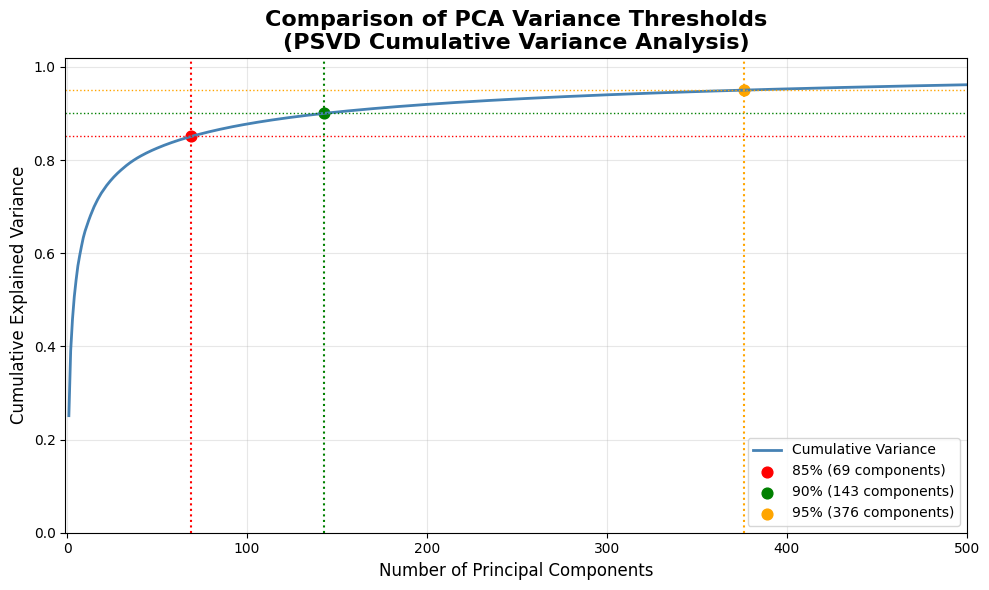

In [11]:
thresholds = [0.85, 0.90, 0.95]
colors = ['red', 'green', 'orange']

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components_initial + 1), cumulative_variance, color='steelblue', linewidth=2, label='Cumulative Variance')

for thresh, color in zip(thresholds, colors):
    idx = np.argmax(cumulative_variance >= thresh) + 1
    var_at_thresh = cumulative_variance[idx - 1]

    plt.axvline(x=idx, color=color, linestyle=':', linewidth=1.5)
    plt.axhline(y=var_at_thresh, color=color, linestyle=':', linewidth=1)
    plt.scatter(idx, var_at_thresh, color=color, s=60, label=f'{thresh*100:.0f}% ({idx} components)')

plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('Comparison of PCA Variance Thresholds\n(PSVD Cumulative Variance Analysis)', fontsize=16, fontweight='bold')
plt.legend()

plt.grid(alpha=0.3)
plt.xlim(-1, n_components_initial)
plt.ylim(0, 1.02)
plt.tight_layout()
plt.savefig('PSVD_cumulative_variance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### Transform Images

The dimensionality reduction transforms each image from the original $d$-dimensional space to the reduced $k^*$-dimensional principal component space:

$$\mathbf{Z} = \mathbf{X}_{\text{centered}}\mathbf{V}_{k^*}^T$$

where $\mathbf{V}_{k^*} \in \mathbb{R}^{k^* \times d}$ contains the first $k^*$ principal components, and $\mathbf{Z} \in \mathbb{R}^{n \times k^*}$ is the transformed representation.

In [12]:
# Transform to principal component space using PSVD
Vt_reduced = Vt[:n_components_final, :]
images_transformed = np.dot(image_data, Vt_reduced.T)

print(f"Transformed image data shape: {images_transformed.shape}")

Transformed image data shape: (7632, 143)


### Reconstruct Images from Reduced Dimensions

Inverse transform the reduced representations back to the original image space.

In [13]:
# Inverse transform from PSVD space
images_reconstructed_centered = np.dot(images_transformed, Vt_reduced)
images_reconstructed = images_reconstructed_centered + mean_vector
images_reconstructed = np.clip(images_reconstructed, 0, 1)

print(f"Reconstructed image data shape: {images_reconstructed.shape}")

Reconstructed image data shape: (7632, 14400)


### Save Transformed Images

In [14]:
output_dir = "C:\\Users\\Admin\\DATA\\fashion-dataset\\images_psvd"

os.makedirs(output_dir, exist_ok=True)

for i, img_id in enumerate(df['id']):
    img_flat = images_reconstructed[i]
    img_reshaped = img_flat.reshape(target_size[1], target_size[0], 3)
    img_array = (img_reshaped * 255).astype(np.uint8)
    img_pil = Image.fromarray(img_array, mode='RGB')
    
    output_path = os.path.join(output_dir, f"{img_id}.jpg")
    img_pil.save(output_path)

### Principal component visualizaton

visualization of first two principal components

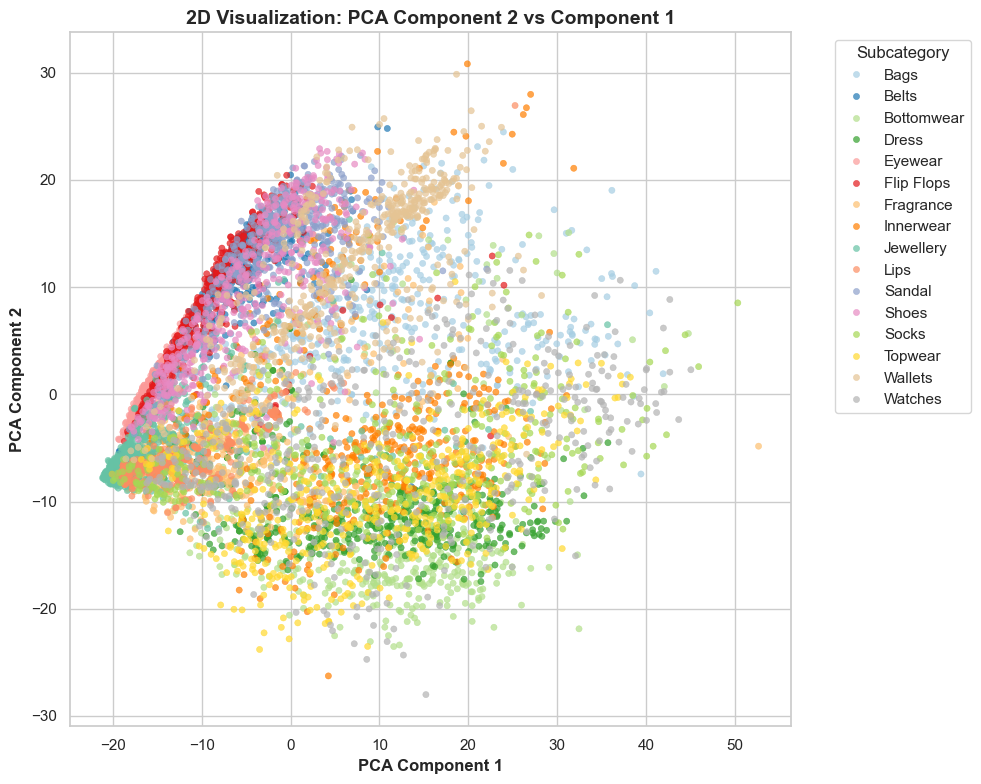

In [15]:
# Create visualization of first two principal components
plot_df = pd.DataFrame({
    'PC1': -images_transformed[:, 0],
    'PC2': images_transformed[:, 1],
    'Subcategory': df['subCategory'].values
})

palette = sns.color_palette("Paired", 8) + sns.color_palette("Set2", 8)
sns.set(style='whitegrid', context='notebook')

plt.figure(figsize=(10, 8))
sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Subcategory',
                palette=palette, s=20, alpha=0.7, edgecolor=None)

plt.title('2D Visualization: PCA Component 2 vs Component 1', fontsize=14, fontweight='bold')
plt.xlabel('PCA Component 1', fontsize=12, fontweight='bold')
plt.ylabel('PCA Component 2', fontsize=12, fontweight='bold')
plt.legend(title='Subcategory', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('PCA_component_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

## K-means++ Clustering Analysis

Implementation of K-means++ clustering on the PSVD-transformed images. This section details the application of the K-means++ algorithm to partition the dataset into clusters based on the reduced-dimension image features. The primary objective of K-means is to minimize the within-cluster sum of squares (WCSS), also known as inertia. The objective function is defined as:

$$
\arg\min_C \sum_{i=1}^{k} \sum_{\mathbf{x} \in C_i} \left\| \mathbf{x} - \boldsymbol{\mu}_i \right\|^2
$$

where $C_i$ is the $i$-th cluster, $\boldsymbol{\mu}_i$ is the centroid of cluster $C_i$, and $k$ is the number of clusters. The process includes:

1.  Testing various cluster numbers from 8 to 16.
2.  Computing inertia for each configuration to determine the optimal cluster count.
3.  Applying K-means++ with optimal parameters.
4.  Visualizing results using t-SNE for dimensionality reduction.

### Determine Optimal Number of Clusters

To determine the optimal number of clusters, the Elbow Method is employed. This technique involves running the K-means algorithm for a range of cluster counts and plotting the inertia (within-cluster sum of squares) for each. The "elbow" point on the plot, where the rate of decrease in inertia sharply changes, suggests the optimal number of clusters. Inertia is calculated as:

$$
\text{Inertia} = \sum_{i=1}^{k} \sum_{\mathbf{x} \in C_i} \left\| \mathbf{x} - \boldsymbol{\mu}_i \right\|^2
$$

This cell tests K-means++ with cluster numbers from 8 to 16 and computes the inertia for each configuration.

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
cluster_range = range(8, 17)
inertias = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(images_transformed)
    
    inertias.append(kmeans.inertia_)

### Visualize Clustering Metrics

The inertia values computed for each cluster count (from 8 to 16) are plotted to visualize the Elbow Method. The resulting graph helps in identifying the point where adding more clusters does not significantly reduce the inertia, indicating the optimal number of clusters for the dataset. This visualization is crucial for balancing model complexity with its explanatory power.

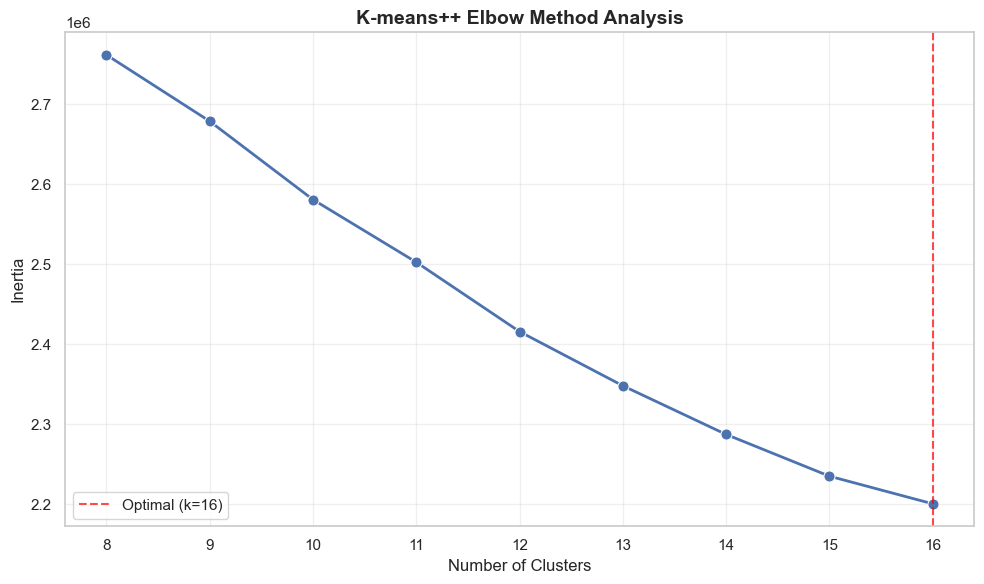

In [18]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=cluster_range, y=inertias, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('K-means++ Elbow Method Analysis', fontsize=14, fontweight='bold')
plt.axvline(x=16, color='red', linestyle='--', alpha=0.7, label='Optimal (k=16)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('elbow_method_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### Apply K-means++ with Optimal Parameters

Based on the Elbow Method analysis and the research methodology, K-means++ clustering is implemented with $k=16$ clusters. K-means++ improves upon the standard K-means algorithm by using a smarter initialization technique for the cluster centroids, which helps in avoiding poor clustering results. The steps are as follows:

1.  **Initialization**: The first centroid is chosen uniformly at random from the data points.
2.  **Seeding**: For each subsequent centroid, a data point is chosen with a probability proportional to the squared distance from the point's closest existing centroid. This is formally defined as:
    $$
    P(\text{point } x) = \frac{D(x)^2}{\sum_{j=1}^{n} D(x_j)^2}
    $$
    where $D(x)$ is the distance from point $x$ to the nearest centroid that has already been chosen.
3.  **Clustering**: Once all $k$ centroids are initialized, the standard K-means algorithm proceeds by assigning points to the nearest centroid and updating the centroids iteratively.

In [19]:
kmeans_final = KMeans(
    n_clusters=16, 
    init='k-means++', 
    random_state=42, 
    n_init=10,
    max_iter=300
)

cluster_labels_final = kmeans_final.fit_predict(images_transformed)
final_inertia = kmeans_final.inertia_

In [20]:
print(f"Number of iterations to converge: {kmeans_final.n_iter_}")
print(f"Final inertia: {final_inertia:.2f}")

true_labels = df['subCategory'].values
rows = []
total_correct = 0

for cluster_id in range(16):
    mask = cluster_labels_final == cluster_id
    cluster_subcats = true_labels[mask]
    
    if len(cluster_subcats) == 0:
        continue  # skip empty clusters
    
    subcats, counts = np.unique(cluster_subcats, return_counts=True)
    max_idx = counts.argmax()
    
    purity = counts[max_idx] / len(cluster_subcats)
    total_correct += counts[max_idx]
    
    # collect results
    rows.append({
        "Cluster": cluster_id,
        "Count": len(cluster_subcats),
        "Purity": round(purity, 3),
        "Dominant Subcategory": subcats[max_idx],
        "Dominant Count": counts[max_idx]
    })

overall_purity = total_correct / len(cluster_labels_final)
print(f"\nOverall Purity: {overall_purity:.4f} ({overall_purity*100:.2f}%)")

cluster_summary = pd.DataFrame(rows)
cluster_summary["% of Total"] = (cluster_summary["Count"] / len(cluster_labels_final) * 100).round(2)

cluster_summary

Number of iterations to converge: 38
Final inertia: 2200426.50

Overall Purity: 0.5063 (50.63%)


,Cluster,Count,Purity,Dominant Subcategory,Dominant Count,% of Total
0,0,232,0.461,Bags,107,3.04
1,1,686,0.308,Fragrance,211,8.99
2,2,1558,0.274,Jewellery,427,20.41
3,3,479,0.478,Dress,229,6.28
4,4,314,0.503,Wallets,158,4.11
5,5,380,0.958,Belts,364,4.98
6,6,444,0.514,Sandal,228,5.82
7,7,237,0.983,Socks,233,3.11
8,8,744,0.630,Eyewear,469,9.75
9,9,305,0.734,Innerwear,224,4.00


### t-SNE Visualization of Clustered Data

To visualize the high-dimensional cluster assignments in a lower-dimensional space, t-Distributed Stochastic Neighbor Embedding (t-SNE) is applied. t-SNE is a non-linear dimensionality reduction technique that is particularly well-suited for visualizing high-dimensional datasets. It models the similarity between high-dimensional data points as a probability distribution and then optimizes a similar distribution in a low-dimensional space.

The similarity between two points $\mathbf{x}_i$ and $\mathbf{x}_j$ in the high-dimensional space is represented by the conditional probability $p_{j|i}$:

$$
p_{j|i} = \frac{\exp(-\|\mathbf{x}_i - \mathbf{x}_j\|^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-\|\mathbf{x}_i - \mathbf{x}_k\|^2 / 2\sigma_i^2)}
$$

In the low-dimensional space, the similarity between the corresponding points $\mathbf{y}_i$ and $\mathbf{y}_j$ is modeled using a Student's t-distribution with one degree of freedom:

$$
q_{ij} = \frac{(1 + \|\mathbf{y}_i - \mathbf{y}_j\|^2)^{-1}}{\sum_{k \neq l} (1 + \|\mathbf{y}_k - \mathbf{y}_l\|^2)^{-1}}
$$

t-SNE minimizes the Kullback-Leibler (KL) divergence between the joint probability distributions $P$ and $Q$:

$$
\text{KL}(P\|Q) = \sum_{i \neq j} p_{ij} \log \frac{p_{ij}}{q_{ij}}
$$

This cell applies t-SNE to both the PSVD-transformed data and the original image data to visualize the cluster segregation.

In [21]:
tsne_psvd = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
tsne_transformed = tsne_psvd.fit_transform(images_transformed)

tsne_original = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
tsne_original_data = tsne_original.fit_transform(image_data)

### Create t-SNE Visualizations

Generate the visualization plots corresponding to transformed data and original data.

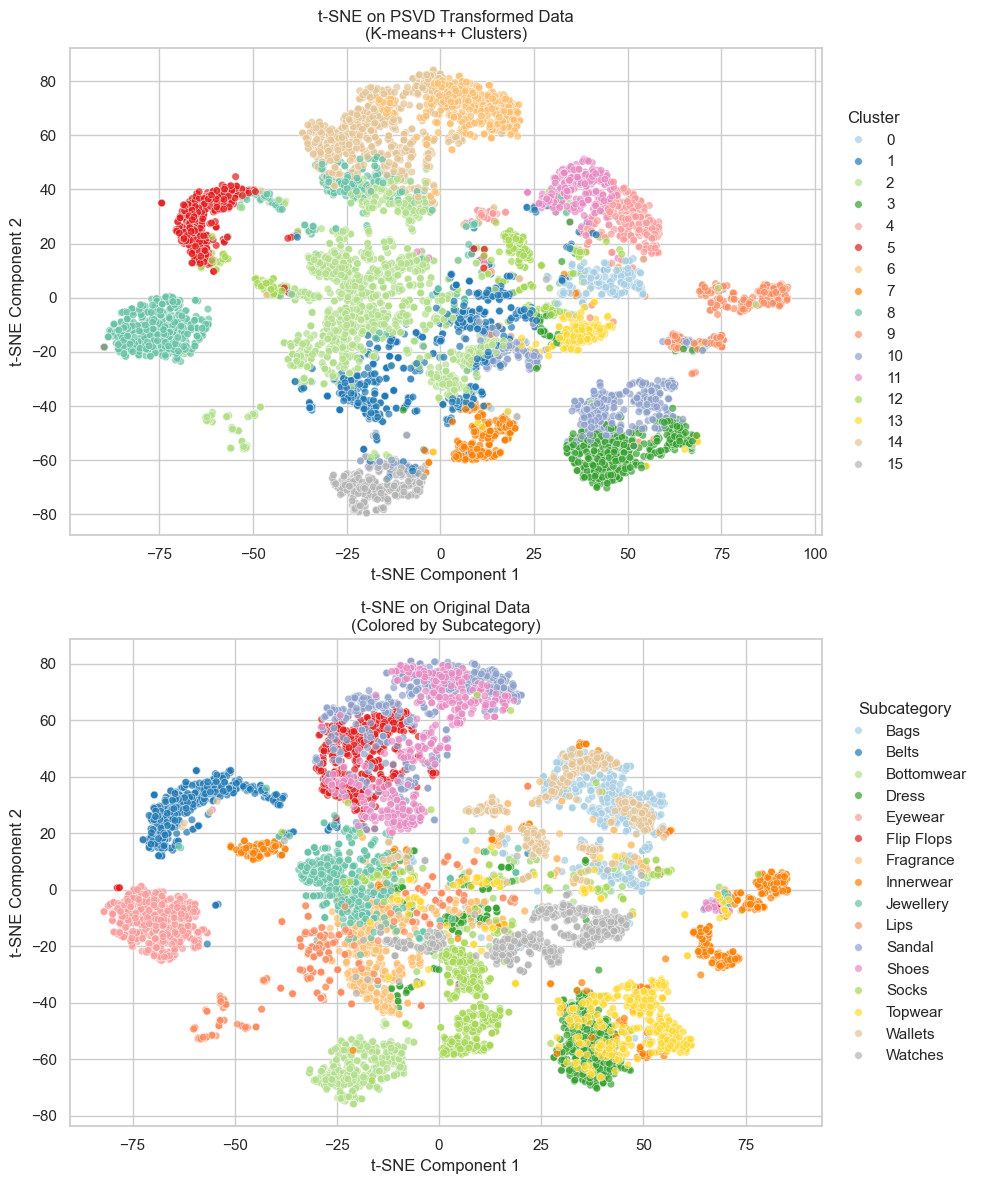

In [22]:
palette = sns.color_palette("Paired", 8) + sns.color_palette("Set2", 8)
sns.set(style="whitegrid")

tsne_df = pd.DataFrame({
    'x_psvd': tsne_transformed[:, 0],
    'y_psvd': tsne_transformed[:, 1],
    'x_orig': tsne_original_data[:, 0],
    'y_orig': tsne_original_data[:, 1],
    'Cluster': cluster_labels_final,
    'Subcategory': df['subCategory'].values
})

fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot 1: PSVD clusters
sns.scatterplot(
    data=tsne_df, x='x_psvd', y='y_psvd',
    hue='Cluster', palette=palette,
    s=30, alpha=0.7, ax=axes[0], legend='brief'
)
axes[0].set(
    title='t-SNE on PSVD Transformed Data\n(K-means++ Clusters)',
    xlabel='t-SNE Component 1',
    ylabel='t-SNE Component 2'
)
axes[0].legend(
    title='Cluster',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0,
    frameon=False
)

# Plot 2: Original data
sns.scatterplot(
    data=tsne_df, x='x_orig', y='y_orig',
    hue='Subcategory', palette=palette,
    s=30, alpha=0.7, ax=axes[1], legend='brief'
)
axes[1].set(
    title='t-SNE on Original Data\n(Colored by Subcategory)',
    xlabel='t-SNE Component 1',
    ylabel='t-SNE Component 2'
)
axes[1].legend(
    title='Subcategory',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0,
    frameon=False
)

plt.tight_layout()
plt.subplots_adjust(right=0.83) 
plt.savefig('t-SNE_vertical_legends.png', dpi=300, bbox_inches='tight')
plt.show()

## Results

This section evaluates the performance of K-means++ clustering and compares it with other standard clustering algorithms. The evaluation is based on several key metrics designed to measure the quality of the resulting clusters. The metrics used are:

1.  **Silhouette Coefficient (SC)**
2.  **Calinski-Harabasz (CH) Score**
3.  **Davies-Bouldin (DB) Index**

The evaluation also includes a comparison with standard clustering algorithms (MiniBatch K-means, K-Medoids, Agglomerative, Birch, GMM), an analysis of computational wall time, and a demonstration of top-K product recommendations using Manhattan distance.

### Train Multiple Clustering Algorithms

Implementation and comparison of K-means++, MiniBatch K-means, K-Medoids, Agglomerative, Birch, and GMM clustering algorithms on PSVD-transformed data.

In [23]:
def get_clustering_model(name, n_clusters):
    models = {
        'K-means++': KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10),
        'MiniBatch K-means': MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=100),
        'K-Medoids': KMedoids(n_clusters=n_clusters, random_state=42, method='pam'),
        'Agglomerative': AgglomerativeClustering(n_clusters=n_clusters, linkage='ward'),
        'Birch': Birch(n_clusters=n_clusters, threshold=0.5),
        'GMM': GaussianMixture(n_components=n_clusters, random_state=42, covariance_type='full')
    }
    return models[name]

In [24]:
n_clusters = 16
algorithm_names = ['K-means++', 'MiniBatch K-means', 'K-Medoids', 'Agglomerative', 'Birch', 'GMM']

results = {}
computation_times = {}

for name in algorithm_names:
    model = get_clustering_model(name, n_clusters)
    intervals = {}
    
    start = time.time()
    labels = model.fit_predict(images_transformed)
    intervals['fitting'] = time.time() - start
    
    start = time.time()
    sc = silhouette_score(images_transformed, labels)
    intervals['sc'] = time.time() - start

    start = time.time()
    ch = calinski_harabasz_score(images_transformed, labels)
    intervals['ch'] = time.time() - start

    start = time.time()
    db = davies_bouldin_score(images_transformed, labels)
    intervals['db'] = time.time() - start

    results[name] = labels
    computation_times[name] = {
        'fitting': intervals['fitting'],
        'sc': intervals['sc'],
        'ch': intervals['ch'],
        'db': intervals['db'],
        'sc_value': sc,
        'ch_value': ch,
        'db_value': db
    }

### Compute Evaluation Metrics

Calculate Silhouette Coefficient, Calinski-Harabasz Score, and Davies-Bouldin Index for all clustering algorithms.

In [25]:
evaluation_metrics = {
    'Algorithm': [],
    'Silhouette Coefficient': [],
    'Calinski-Harabasz Score': [],
    'Davies-Bouldin Index': [],
    'Fitting Time (s)': [],
    'SC Time (s)': [],
    'CH Time (s)': [],
    'DB Time (s)': []
}

for name in results.keys():
    evaluation_metrics['Algorithm'].append(name)
    evaluation_metrics['Silhouette Coefficient'].append(computation_times[name]['sc_value'])
    evaluation_metrics['Calinski-Harabasz Score'].append(computation_times[name]['ch_value'])
    evaluation_metrics['Davies-Bouldin Index'].append(computation_times[name]['db_value'])
    evaluation_metrics['Fitting Time (s)'].append(computation_times[name]['fitting'])
    evaluation_metrics['SC Time (s)'].append(computation_times[name]['sc'])
    evaluation_metrics['CH Time (s)'].append(computation_times[name]['ch'])
    evaluation_metrics['DB Time (s)'].append(computation_times[name]['db'])

metrics_df = pd.DataFrame(evaluation_metrics)
metrics_df

,Algorithm,Silhouette Coefficient,Calinski-Harabasz Score,Davies-Bouldin Index,Fitting Time (s),SC Time (s),CH Time (s),DB Time (s)
0,K-means++,0.142616,670.778262,1.857070,1.124532,1.897696,0.019026,0.018577
1,MiniBatch K-means,0.122251,591.979222,2.087996,0.292261,1.600465,0.013438,0.017289
2,K-Medoids,0.130783,644.435311,1.931993,661.100802,1.191605,0.011325,0.019554
3,Agglomerative,0.117080,592.532161,2.019932,5.255228,1.385734,0.012211,0.013400
4,Birch,0.113565,601.019232,1.933640,4.625107,1.272176,0.009886,0.010765
5,GMM,0.065726,471.671644,2.330624,20.752292,1.283024,0.010930,0.017183


### Compute Metrics Across Different Cluster Numbers

Evaluate all clustering algorithms with varying cluster numbers (8-16) to analyze performance trends. This computes all metrics in a single pass to avoid redundant model fitting.

In [26]:
cluster_range_eval = range(8, 17)
all_metrics = {name: {'sc': [], 'ch': [], 'db': []} for name in algorithm_names}

for k in cluster_range_eval:
    for name in algorithm_names:
        model = get_clustering_model(name, k)
        temp_labels = model.fit_predict(images_transformed)
        
        all_metrics[name]['sc'].append(silhouette_score(images_transformed, temp_labels))
        all_metrics[name]['ch'].append(calinski_harabasz_score(images_transformed, temp_labels))
        all_metrics[name]['db'].append(davies_bouldin_score(images_transformed, temp_labels))

### Silhouette Coefficient Comparison

The Silhouette Coefficient is a measure of how well-defined the clusters are. It is calculated for each sample and is composed of two scores:

-   **a**: The mean distance between a sample and all other points in the same cluster.
-   **b**: The mean distance between a sample and all other points in the *next nearest* cluster.

The Silhouette Coefficient for a single sample is then given by:

$$
s = \frac{b - a}{\max(a, b)}
$$

The score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. This cell compares the Silhouette Coefficient across all clustering algorithms for a range of cluster numbers (8-16).

In [27]:

def plot_metric(metric_key, metric_name, color, save_name):
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    axes = axes.flatten()

    for idx, name in enumerate(results.keys()):
        data = {
            "Clusters": cluster_range_eval,
            "Score": all_metrics[name][metric_key]
        }
        sns.lineplot(
            data=data, x="Clusters", y="Score", 
            ax=axes[idx], marker="o", color=color, linewidth=2, markersize=8
        )
        axes[idx].axvline(x=16, color='red', linestyle='--', alpha=0.7, label='k=16')
        axes[idx].set_title(name, fontsize=12, fontweight='bold')
        axes[idx].set_xlabel("Number of Clusters", fontsize=10)
        axes[idx].set_ylabel(metric_name, fontsize=10)
        axes[idx].grid(alpha=0.3)
        axes[idx].legend()
        
    plt.suptitle(f'{metric_name} Comparison Across Clustering Algorithms',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(f'{save_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

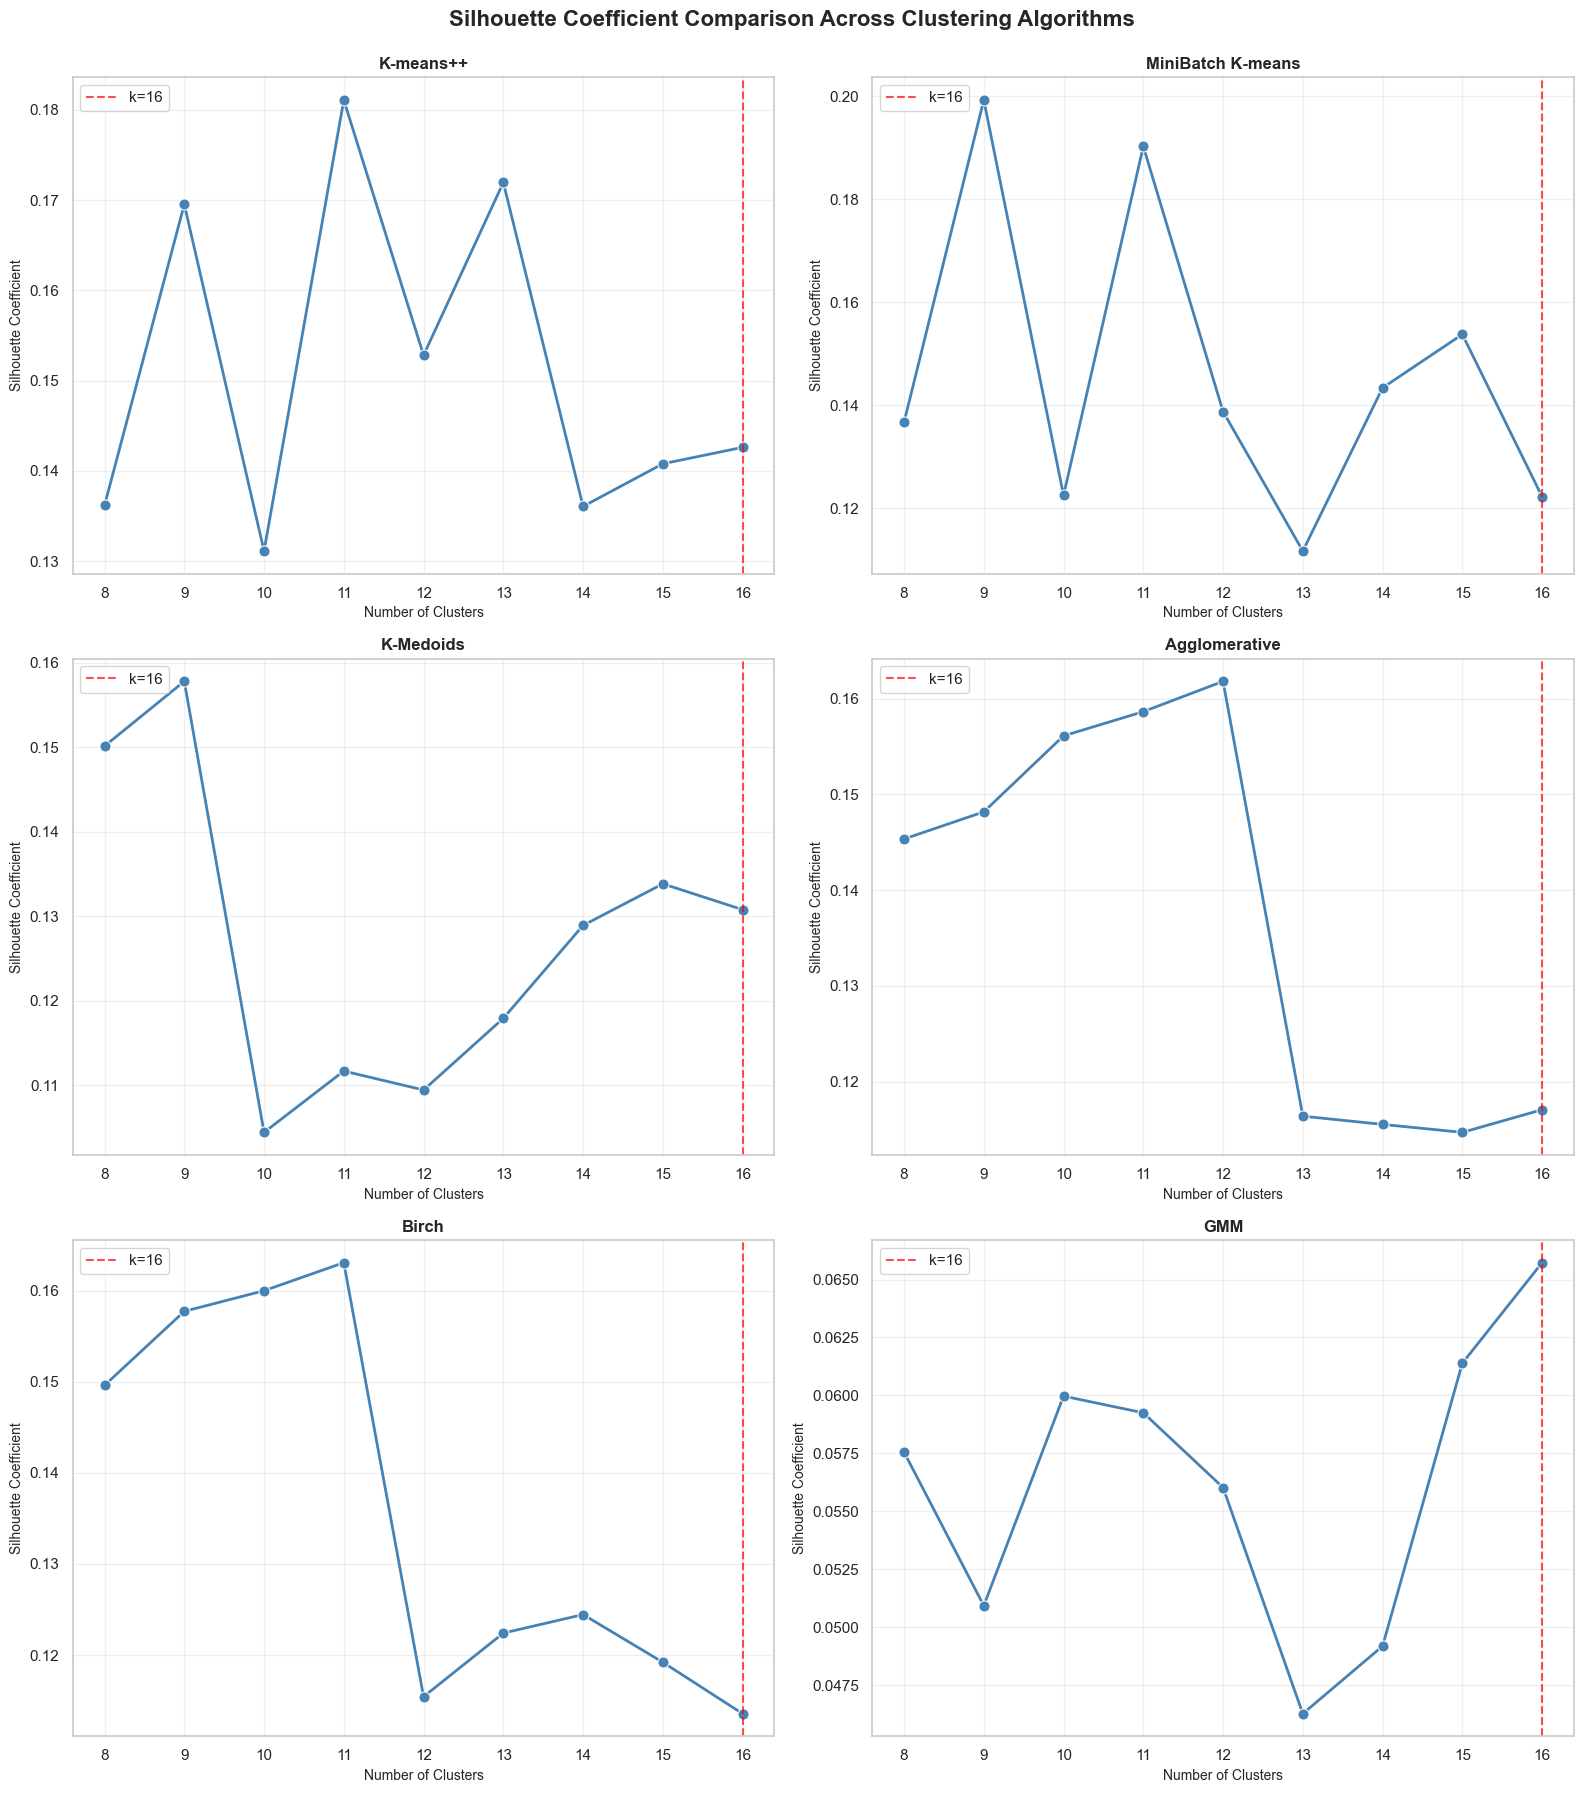

In [28]:
plot_metric('sc', 'Silhouette Coefficient', 'steelblue', 'silhouette_comparison')

### Calinski-Harabasz Score Comparison

The Calinski-Harabasz (CH) score, also known as the Variance Ratio Criterion, is a metric for evaluating clustering performance. It is defined as the ratio of the sum of between-cluster dispersion to the sum of within-cluster dispersion for all clusters. A higher CH score indicates that the clusters are dense and well-separated.

The formula for the CH score is:

$$
\text{CH} = \frac{\text{Tr}(B_k)}{\text{Tr}(W_k)} \times \frac{N - k}{k - 1}
$$

where:
-   $N$ is the total number of data points.
-   $k$ is the number of clusters.
-   $\text{Tr}(B_k)$ is the trace of the between-cluster dispersion matrix.
-   $\text{Tr}(W_k)$ is the trace of the within-cluster dispersion matrix.

This cell compares the CH score across all clustering algorithms for a range of cluster numbers (8-16).

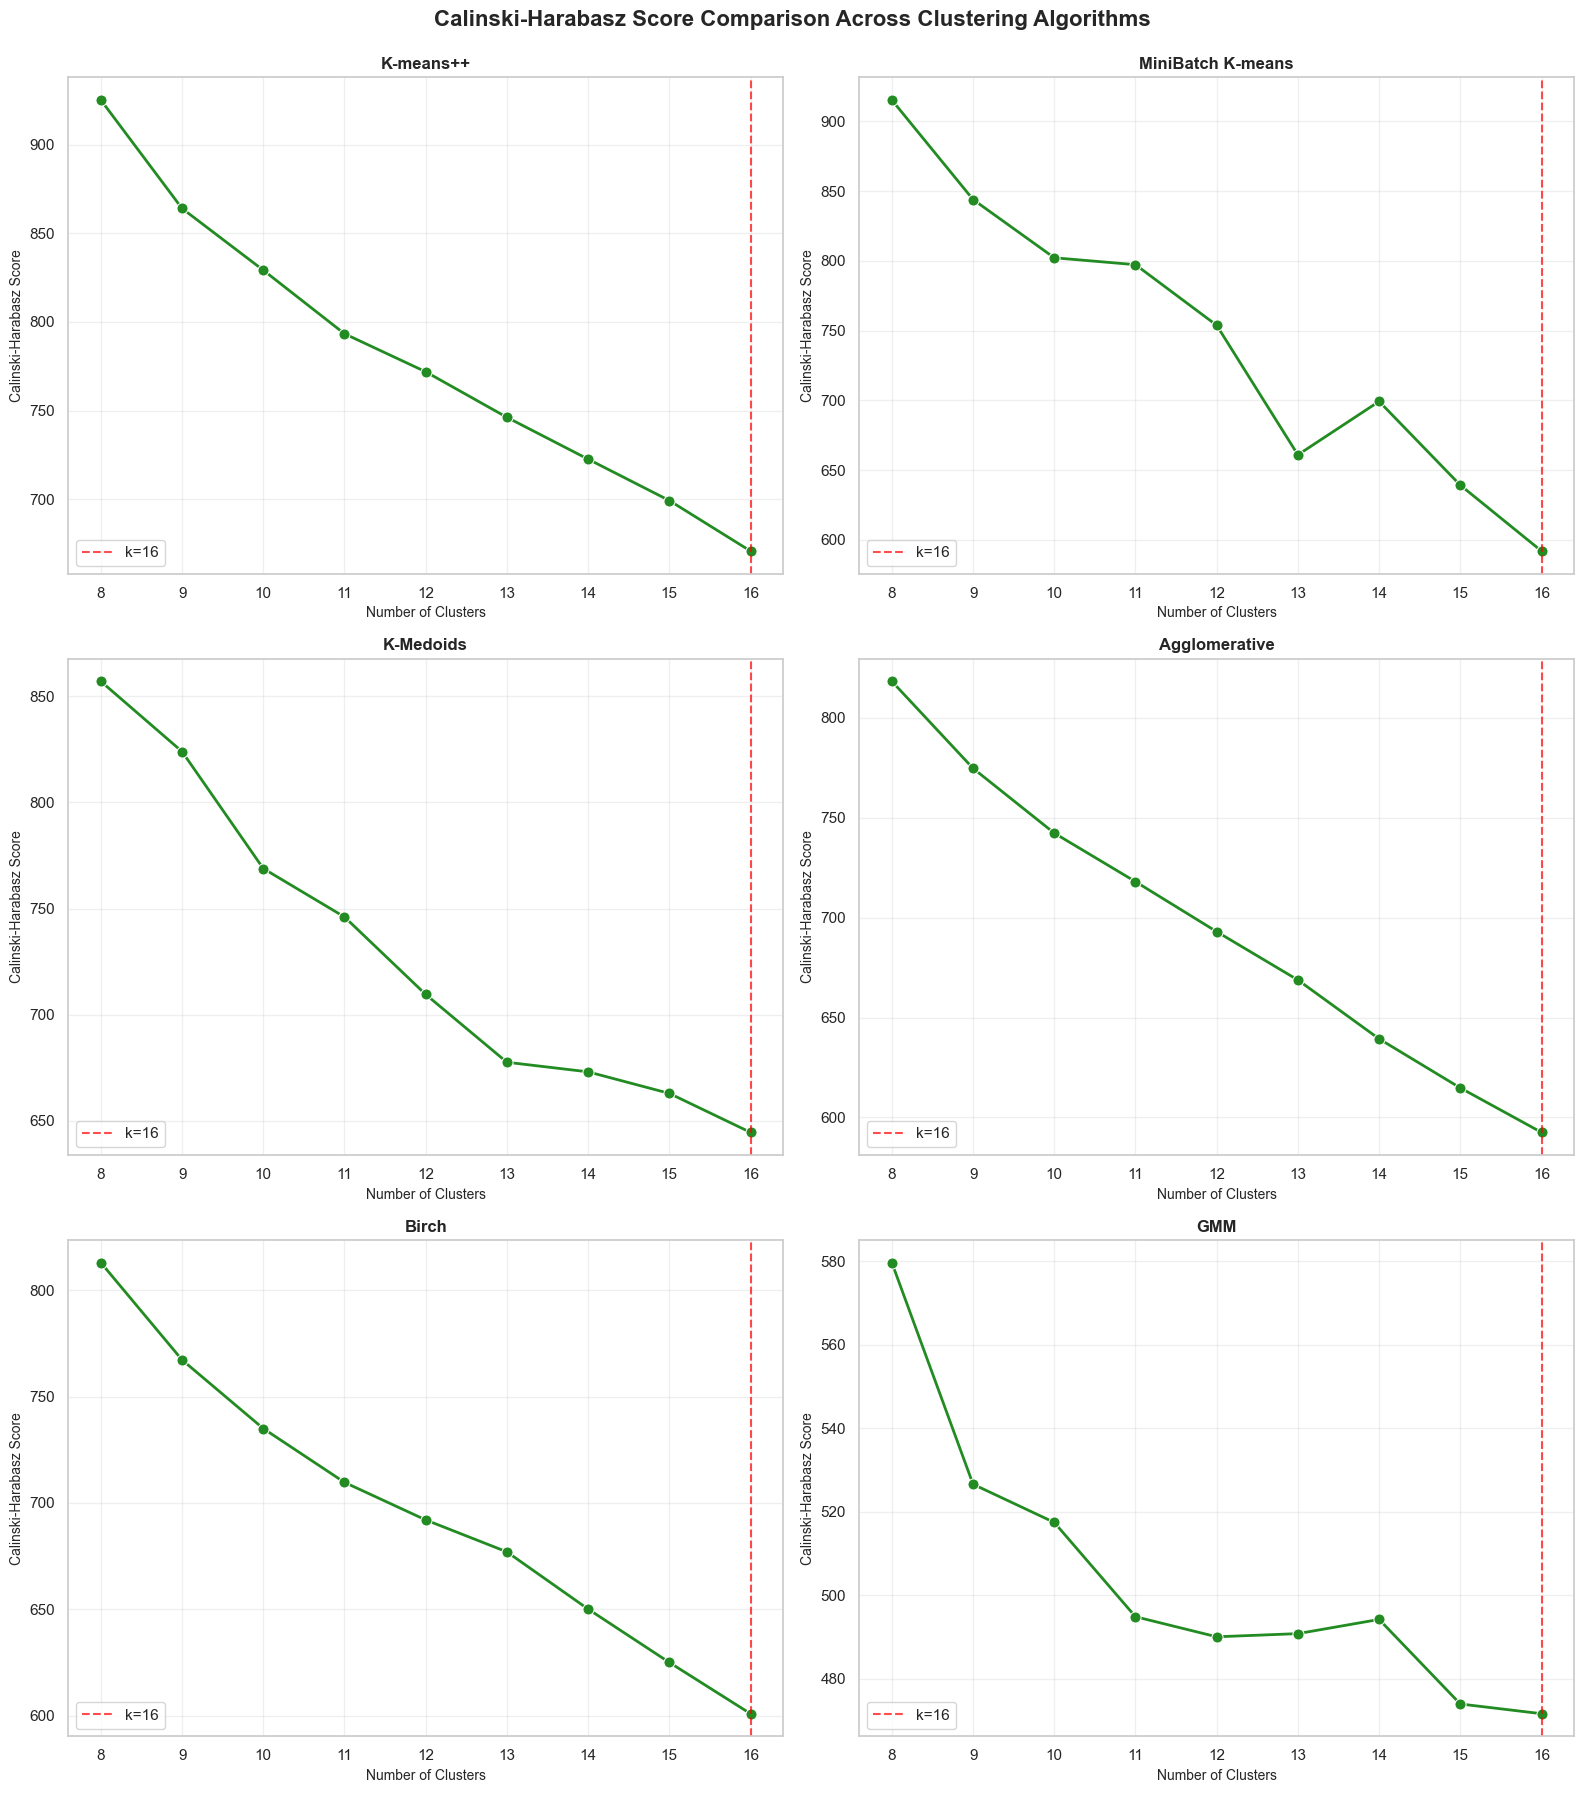

In [29]:
plot_metric('ch', 'Calinski-Harabasz Score', 'forestgreen', 'calinski_harabasz_comparison')

### Davies-Bouldin Index Comparison

The Davies-Bouldin (DB) index is a metric for evaluating clustering algorithms. It is defined as the average similarity measure of each cluster with its most similar cluster. A lower DB index indicates better clustering, as it signifies that the clusters are more separated from each other.

The similarity between two clusters is defined as the sum of their intra-cluster dispersions divided by the distance between their centroids. The DB index is calculated as:

$$
\text{DB} = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \left( \frac{\sigma_i + \sigma_j}{d(c_i, c_j)} \right)
$$

where:
-   $k$ is the number of clusters.
-   $\sigma_i$ is the average distance of all points in cluster $i$ from its centroid $c_i$.
-   $d(c_i, c_j)$ is the distance between the centroids of clusters $i$ and $j$.

This cell compares the DB index across all clustering algorithms for a range of cluster numbers (8-16).

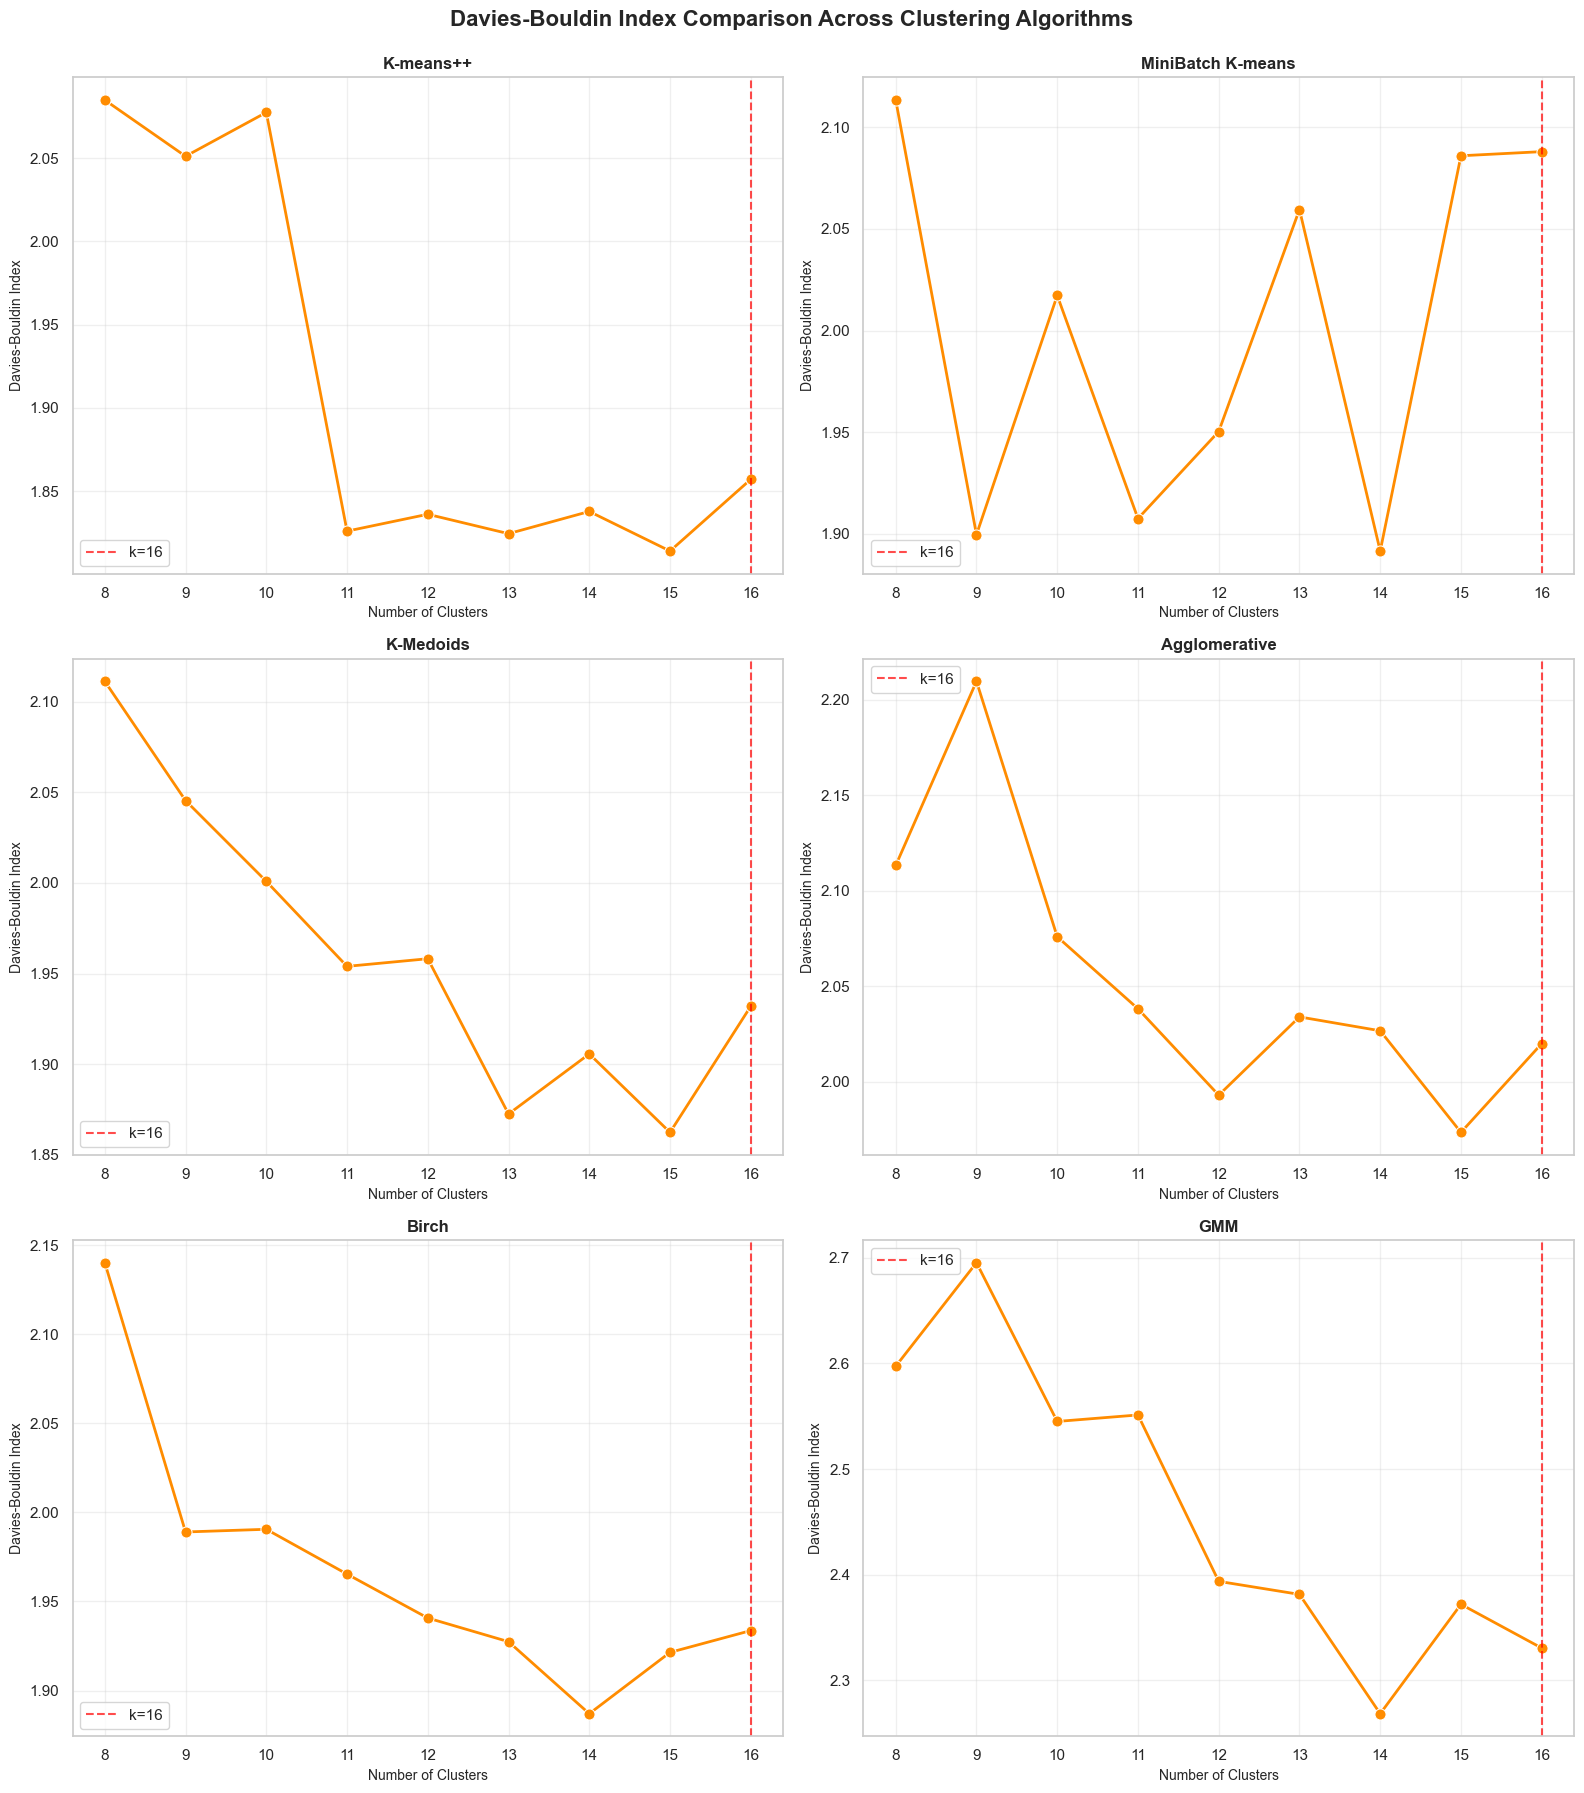

In [30]:
plot_metric('db', 'Davies-Bouldin Index', 'darkorange', 'davies_bouldin_comparison')

### Performance Comparison Table

Summary table comparing all clustering algorithms on PSVD-transformed data.

In [31]:

def create_table(data, columns, title, filename=None):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.axis("off")

    table_data = [columns] + data
    col_widths = [max(0.1, 1.0 / len(columns))] * len(columns)
    
    # Create table
    table = ax.table(cellText=table_data, cellLoc="center", loc="center", colWidths=col_widths)

    # Font and scale
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.0, 2.0)

    # Header
    for col in range(len(columns)):
        cell = table[(0, col)]
        cell.set_facecolor("#1F4E79")
        cell.set_text_props(weight="bold", color="white", fontsize=11)
        cell.set_edgecolor("white")

    # Body rows
    for row in range(1, len(table_data)):
        row_color = ("#F9F9F9", "white")[row % 2]
        for col in range(len(columns)):
            cell = table[(row, col)]
            cell.set_facecolor(row_color)
            cell.set_edgecolor("#DADADA")

    plt.title(title, fontsize=14, fontweight="bold", pad=25, color="#333333")
    plt.tight_layout()

    if filename:
        plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")
    
    plt.show()

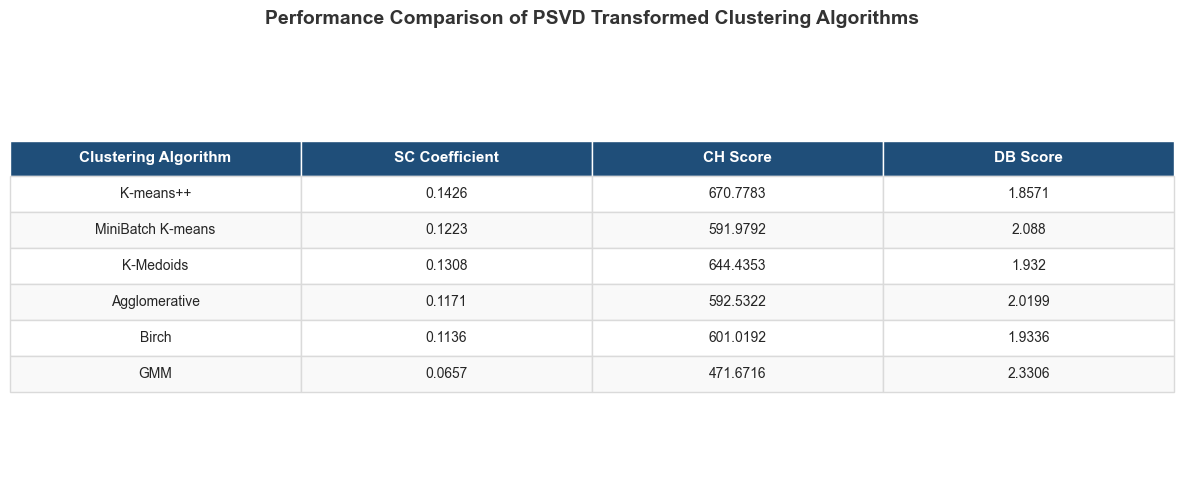

In [32]:

perf_data = metrics_df[['Algorithm', 'Silhouette Coefficient', 'Calinski-Harabasz Score', 'Davies-Bouldin Index']].round(4).values.tolist()
perf_columns = ['Clustering Algorithm', 'SC Coefficient', 'CH Score', 'DB Score']

create_table(perf_data, perf_columns, 
             'Performance Comparison of PSVD Transformed Clustering Algorithms',
             'performance_comparison_table.png')

### Computational Wall Time Analysis

Detailed comparison of computation times and evaluation metrics for all clustering algorithms.

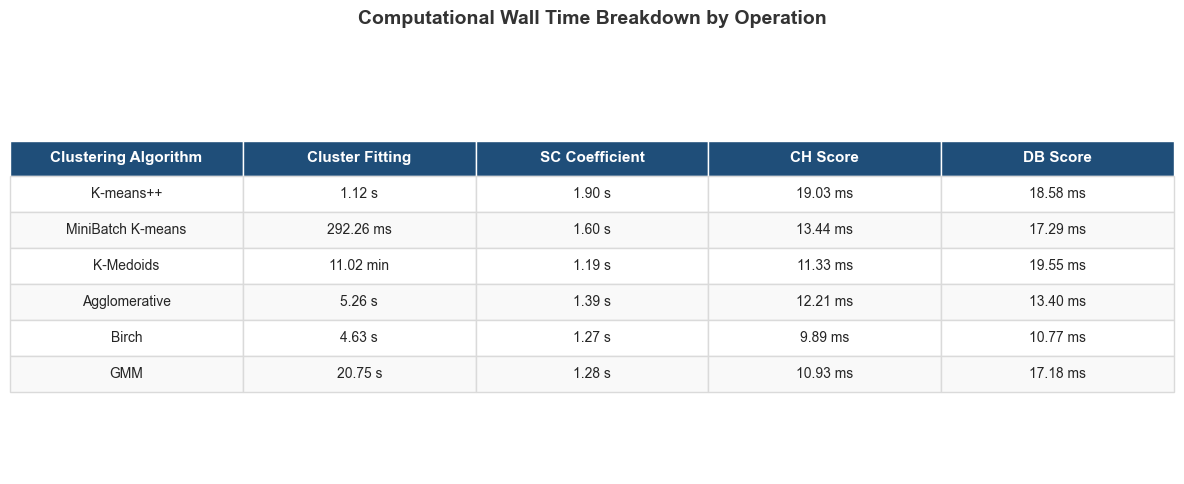

In [33]:
def format_time(seconds):
    if seconds < 1:
        return f"{seconds*1000:.2f} ms"
    elif seconds < 60:
        return f"{seconds:.2f} s"
    else:
        return f"{seconds/60:.2f} min"

time_data = [[name,
              format_time(computation_times[name]['fitting']),
              format_time(computation_times[name]['sc']),
              format_time(computation_times[name]['ch']),
              format_time(computation_times[name]['db'])]
             for name in metrics_df['Algorithm']]

time_columns = ['Clustering Algorithm', 'Cluster Fitting', 'SC Coefficient', 'CH Score', 'DB Score']

create_table(time_data, time_columns,
             'Computational Wall Time Breakdown by Operation',
             'computation_time_breakdown.png')

### Combined Performance and Timing Table

Comprehensive table showing both performance metrics and computational times for all clustering algorithms.

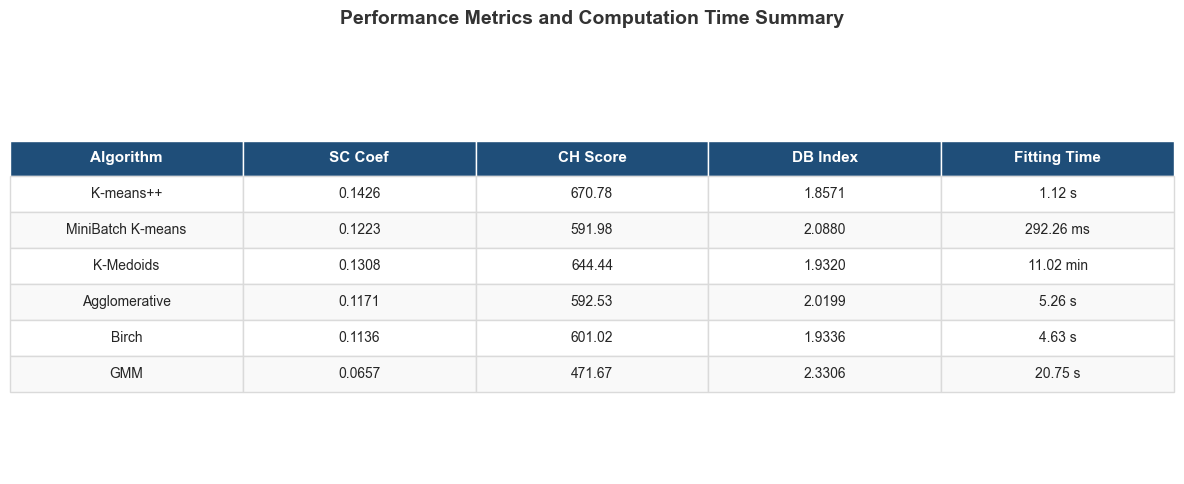

In [34]:
combined_data = [[row['Algorithm'],
                  f"{row['Silhouette Coefficient']:.4f}",
                  f"{row['Calinski-Harabasz Score']:.2f}",
                  f"{row['Davies-Bouldin Index']:.4f}",
                  format_time(row['Fitting Time (s)'])]
                 for _, row in metrics_df.iterrows()]

combined_columns = ['Algorithm', 'SC Coef', 'CH Score', 'DB Index', 'Fitting Time']

create_table(combined_data, combined_columns,
             'Performance Metrics and Computation Time Summary',
             'combined_performance_time_table.png')

### Top-K Product Recommendations Using Manhattan Distance

Implement product recommendation system using Manhattan distance measure to find the top-5 similar products for sample input images.

In [35]:
def manhattan_distance(vec1, vec2):
    return np.sum(np.abs(vec1 - vec2))

def get_top_k_recommendations(query_idx, images_transformed, cluster_labels, k=5):
    query_vector = images_transformed[query_idx]
    query_cluster = cluster_labels[query_idx]
    
    # Get all indices in the same cluster except the query
    cluster_indices = np.setdiff1d(np.where(cluster_labels == query_cluster)[0], [query_idx])
    
    # Compute distances and get top-k
    distances = np.abs(images_transformed[cluster_indices] - query_vector).sum(axis=1)
    top_k_indices = cluster_indices[np.argsort(distances)[:k]]
    
    return top_k_indices

# Select random sample queries from different clusters
np.random.seed(42)
unique_clusters = np.unique(cluster_labels_final)
sample_queries = [
    np.random.choice(np.where(cluster_labels_final == c)[0])
    for c in unique_clusters[:4] if np.any(cluster_labels_final == c)
]

### Visualize Top-5 Recommendations for Sample Images

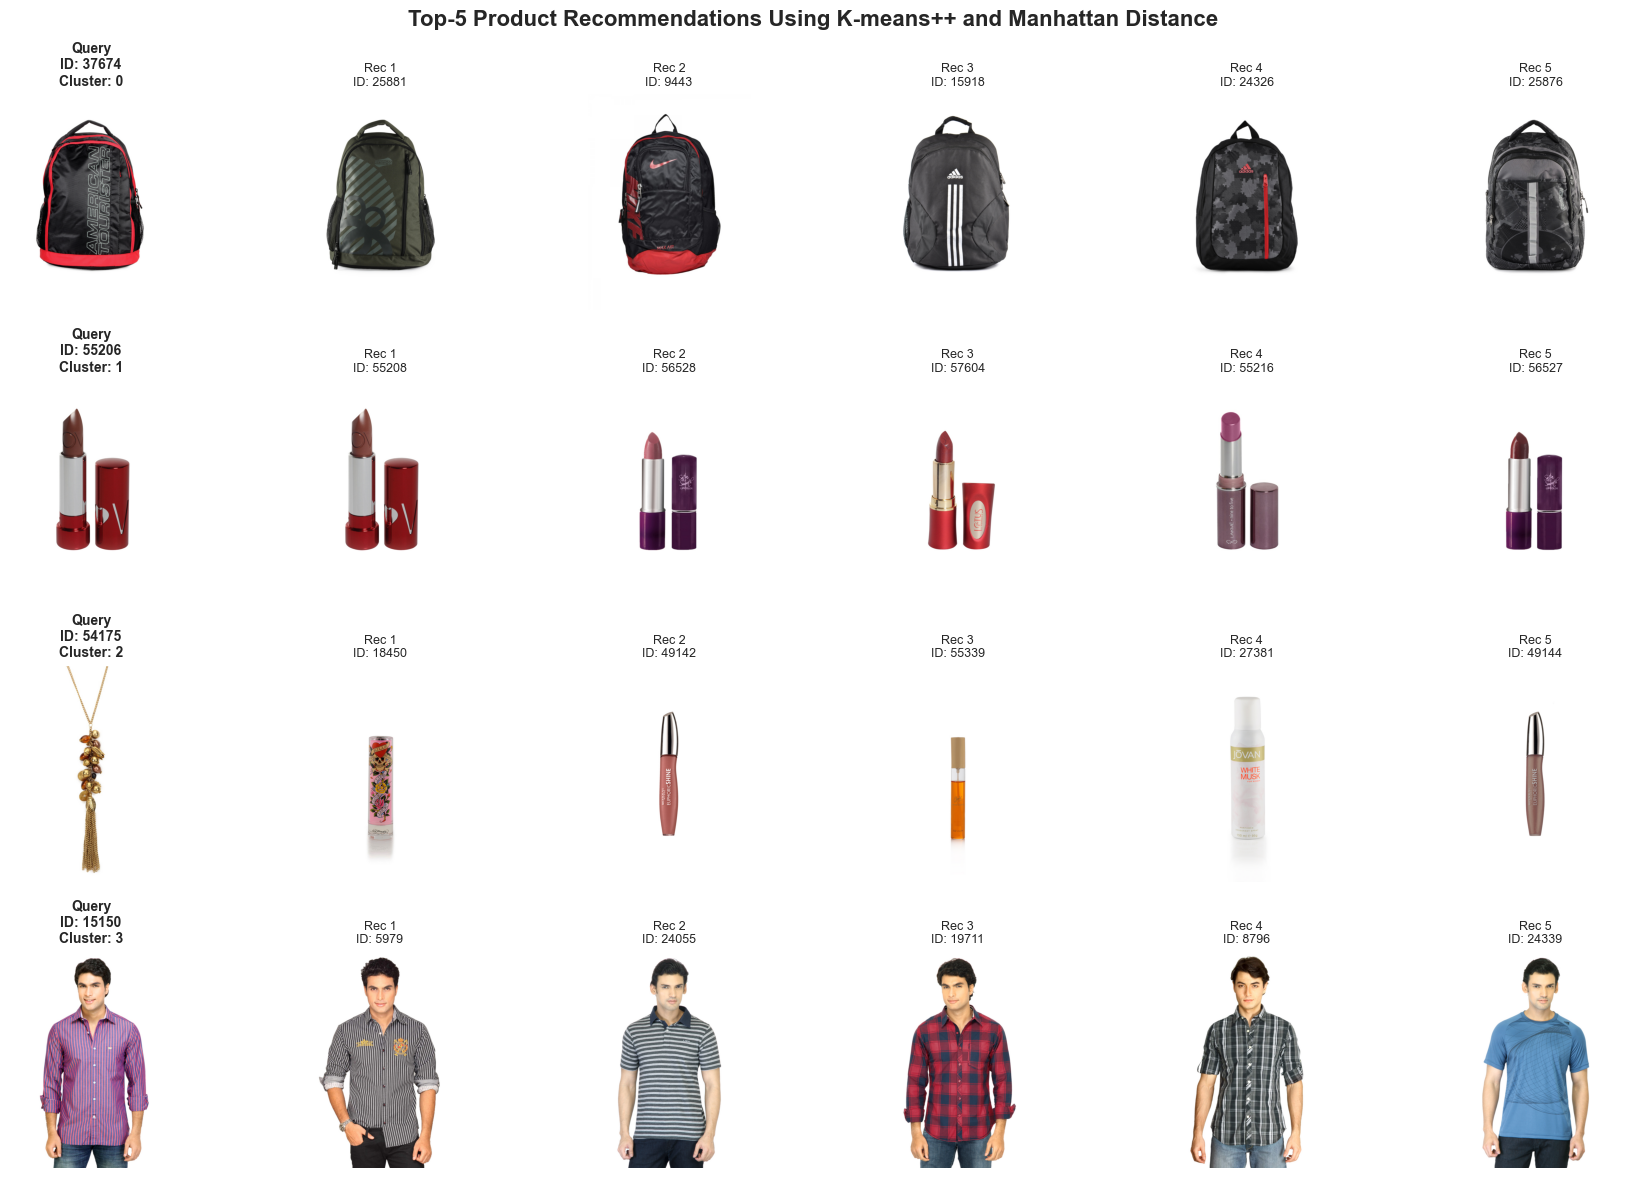

In [36]:
n_queries = len(sample_queries)
fig, axes = plt.subplots(n_queries, 6, figsize=(18, 3 * n_queries))
axes = np.atleast_2d(axes)

for row_idx, query_idx in enumerate(sample_queries):
    query_img_id = df['id'].iloc[query_idx]
    query_path = f"{image_dir}/{query_img_id}.jpg"

    # Query image
    axes[row_idx, 0].imshow(Image.open(query_path))
    axes[row_idx, 0].set_title(
        f"Query\nID: {query_img_id}\nCluster: {cluster_labels_final[query_idx]}",
        fontsize=10, fontweight="bold"
    )
    axes[row_idx, 0].axis("off")

    # Top-k recommendations
    top_k = get_top_k_recommendations(query_idx, images_transformed, cluster_labels_final, k=5)
    for col_idx, rec_idx in enumerate(top_k, start=1):
        rec_img_id = df['id'].iloc[rec_idx]
        rec_path = f"{image_dir}/{rec_img_id}.jpg"
        axes[row_idx, col_idx].imshow(Image.open(rec_path))
        axes[row_idx, col_idx].set_title(f"Rec {col_idx}\nID: {rec_img_id}", fontsize=9)
        axes[row_idx, col_idx].axis("off")

plt.suptitle(
    "Top-5 Product Recommendations Using K-means++ and Manhattan Distance",
    fontsize=16, fontweight="bold", y=0.98
)
plt.tight_layout()
plt.savefig("top5_recommendations.png", dpi=300, bbox_inches="tight")
plt.show()